In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/flickr8k


# CLIP from Scratch


**CLIP** or **Contrastive Language-Image Pre-training** is a model that learns the relationship between a whole sentence and the image it describes; in a sense that when the model is trained, given an input sentence it will be able to retrieve the most related images corresponding to that sentence. The important thing here is that it is trained on full sentences instead of single classes like car, dog, etc. The intuition is that when trained on whole sentences, the model can learn a lot more things and finds some pattern between images and texts.
They also show that when this model is trained on a huge dataset of images and their corresponding texts, it can also act as a classifier too. I encourage you to study the paper to learn more about this exciting model and their astonishing results on benchmarking datasets . To mention just one, CLIP model trained with this strategy classifies ImageNet better than those SOTA models trained on the ImageNet itself optimized for the only task of classification!

As a **teaser**, let's see what the final model that we will build in this article from scratch is capable of: given a query (raw text) like "a boy jumping with skateboard" or "a girl jumping from swing", the model will retrieve the most relevant images:

![](https://i.ibb.co/9gdYqNP/teaser-cropped.png)

In this notebook, we will see how to implement CLIP from Scratch

## Imports

In [ ]:
!pip install -q timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 35.8 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

## Some pre-preocessing

In [ ]:
# Read the captions.txt file
with open( path + "/captions.txt", 'r') as f:
    lines = f.readlines()

# Process each line to separate image filename and caption
data = []
i = 0  # Initialize a counter for caption number
for line in lines[1:]:
    # The format is assumed to be "image_filename,caption"
    parts = line.strip().split(',')
    image_filename = parts[0]
    # Assign caption_number as i mod 5
    caption_number = str(i % 5)
    caption = parts[1]
    data.append([image_filename, caption_number, caption])
    i += 1  # Increment the counter

# Create a DataFrame
new_df = pd.DataFrame(data, columns=['image', 'caption_number', 'caption'])

# Add the 'id' column
# Assuming there are 5 captions per image, assign the same id to 5 consecutive rows
ids = [id_ for id_ in range(len(new_df) // 5) for _ in range(5)]
new_df['id'] = ids

# Display the head of the new DataFrame
display(new_df.head())

# Optionally, save the new DataFrame to a CSV file
new_df.to_csv("captions.csv", index=False)

,image,caption_number,caption,id
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...,0


## Config

In [ ]:
class CFG:
    debug = False
    image_path = "/kaggle/input/flickr8k/Images"
    captions_path = "/content"
    batch_size = 64
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 4
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1
cfg = CFG()

## Utils

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

We need to encode both images and their describing texts. We use **Flickr 30k** dataset that contains 31.8k images and caption pairs.

We will use **DistilBERT** model (which is smaller than BERT but performs nearly as well as BERT) from **HuggingFace** library as our text encoder; so, we need to **tokenize** the sentences (captions) with DistilBERT tokenizer and then feed the token ids (input_ids) and the attention masks to DistilBERT. Therefore, the dataset needs to take care of the tokenization as well. Below you can see the dataset's code. Below that I'll explain the most important things that is happening in the code.

In the **\_\_init\_\_** we receive a tokenizer object which is actually a HuggingFace tokinzer; this tokenizer will be loaded when running the model. We are padding and truncating the captions to a specified max_length. In the **\_\_getitem\_\_** we will first load an encoded caption which is a dictionary with keys input_ids and attention_mask, make tensors out of its values and after that we will load the corresponding image, transform and augment it (if there is any!) and then we make it a tensor and put it in the dictionary with "image" as the key. Finally we put the raw text of the caption with the key "caption" in the dictionary only for visualization purposes.

I did not use additional data augmentations but you can add them if you want to improve the model's performance.

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=cfg.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{cfg.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(cfg.size, cfg.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(cfg.size, cfg.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

The image encoder code is straight forward. I'm using PyTorch Image Models library (timm) here which makes a lot of different image models available from ResNets to EfficientNets and many more. Here we will use a ResNet50 as our image encoder. You can easily use torchvision library to use ResNets if you don't want to install a new library.

The code encodes each image to a fixed size vector with the size of the model's output channels (in case of ResNet50 the vector size will be **2048**). This is the output after the nn.AdaptiveAvgPool2d() layer.

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=cfg.model_name, pretrained=cfg.pretrained, trainable=cfg.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder

I'll use DistilBERT as the text encoder. Like its bigger brother BERT, two special tokens will be added to the actual input tokens: **CLS** and **SEP** which mark the start and end of a sentence. To grab the whole representation of a sentence (as the related BERT and DistilBERT papers point out) we use the final representations of the CLS token and we hope that this representation captures the overall meaning of the sentence (caption). Thinking it in this way, it is similar to what we did to images and converted them into a fixed size vector.

In the case of DistilBERT (and also BERT) the output hidden representation for each token is a vector with size **768**. So, the whole caption will be encoded in the CLS token representation whose size is 768.

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=cfg.text_encoder_model, pretrained=cfg.pretrained, trainable=cfg.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

Now that we have encoded both our images and texts into fixed size vectors (2048 for image and 768 for text) we need to bring (project) them into a _new world_ with **similar dimensions** for both images and texts in order to be able to compare them and push apart the non-relevant image and texts and pull together those that match. So, the following code will bring the 2048 and 768 dimensional vectors into a 256 (projection_dim) dimensional world, where we can **compare** them.

"embedding_dim" is the size of the input vector (2048 for images and 768 for texts) and "projection_dim" is the the size of the output vector which will be 256 for our case. For understanding the details of this part you can refer to the CLIP paper.

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=cfg.projection_dim,
        dropout=cfg.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

![clip.png](attachment:fb0403a4-73b2-4b97-bfec-c824d11677ee.png)

Here we will use the previous modules that we built to implement the main model. The \_\_init\_\_ function is self-explanatory. In the forward function, we first encode the images and texts separately into fixed size vectors (with different dimensionalities). After that, using separate projection modules we project them to that shared world (space) that I talked about previously. Here the encodings will become of similar shape (256 in our case). After that we will compute the loss. Again I recommend reading CLIP paper to get it better but I'll try my best to explain this part.

In Linear Algebra, one common way to measure if two vectors are of similar characteristics (they are like each other) is to calculate their **dot product** (multiplying the matching entries and take the sum of them); if the final number is big, they are alike and if it is small they are not (relatively speaking)!

Let's now understand the loss function. We talked about two vectors, but, what do we have here? We have image_embeddings, a matrix with shape (batch_size, 256) and text_embeddings with shape (batch_size, 256). It means we have two groups of vectors instead of two single vectors. How do we measure how similar two groups of vectors (two matrices) are to each other? Again, with dot product (@ operator in PyTorch does the dot product or matrix multiplication in this case). To be able to multiply these two matrices together, we transpose the second one. Okay, we get a matrix with shape (batch_size, batch_size) which we will call logits. (temperature is equal to 1.0 in our case, so, it does not make a difference. You can play with it and see what difference it makes. Also look at the paper to see why it is here!).

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=cfg.temperature,
        image_embedding=cfg.image_embedding,
        text_embedding=cfg.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

So, in the best case scenario, text_embeddings and image_embedding matricies should be the same because they are describing similar things. Let's think now: if this happens, what would the logits matrix be like? Let's see with a simple example!

In [ ]:
# A simple Example

batch_size = 4
dim = 256
embeddings = torch.randn(batch_size, dim)
out = embeddings @ embeddings.T
print(F.softmax(out, dim=-1))

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


So logits, in the best case, will be a matrix that if we take its softmax, will have 1.0s in the diagonal (An identity matrix to call it with fancy words!). As the loss function's job is to make model's predictions similar to targets (at least in most cases!), we want such a matrix as our target. That's the reason why we are calculating images_similarity and texts_similarity matrices in the code block above.

Now that we've got our targets matrix, we will use simple cross entropy to calculate the actual loss. I've written the full matrix form of cross entropy as a function which you can see in the bottom of the code block.

There's a simpler way to calculate this loss in PyTorch; by doing this: nn.CrossEntropyLoss()(logits, torch.arange(batch_size)). The reason of not using that here is that the dataset we are using has multiple captions for a single image; so, there is the possibility that two identical images with their similar captions exist in a batch (it is rare but it can happen). Taking the loss with this easier method will ignore this possibility and the model learns to pull apart two representations (assume them different)  that are actually the same. Obviously, we don't want this to happen so I calculated the whole target matrix in a way that takes care of these edge cases.

## Train

Here are some funtions to help us load train and valid dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{cfg.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not cfg.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        num_workers=cfg.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(cfg.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(cfg.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter



Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 24 minutes on GPU (even one epoch is enough!).

In [ ]:

train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

model = CLIPModel().to(CFG.device)

params = [
    {"params": model.image_encoder.parameters(), "lr": cfg.image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": cfg.text_encoder_lr},
    {"params": itertools.chain(
        model.image_projection.parameters(), model.text_projection.parameters()
    ), "lr": cfg.head_lr, "weight_decay": cfg.weight_decay}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=cfg.patience, factor=cfg.factor
)
step = "epoch"

best_loss = float('inf')
for epoch in range(cfg.epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model, valid_loader)

    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(), "best.pt")
        print("Saved Best Model!")

    lr_scheduler.step(valid_loss.avg)

/tmp/ipython-input-7-1466040199.py:40: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
/tmp/ipython-input-7-1466040199.py:41: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),
/tmp/ipython-input-7-1466040199.py:47: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
/tmp/ipython-input-7-1466040199.py:48: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),


Epoch: 1


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [ ]:
# prompt: draw a graph
# x axix 1,2,34
# yaxis_1 3.35,1.17,0.673,0.459
# yaxis_2 2.52,2.44,2.54,2.62
# x - label Epoch, y label train_loss, valid_loss

import matplotlib.pyplot as plt
epochs = [1, 2, 3, 4]
train_losses = [3.35, 1.17, 0.673, 0.459]
valid_losses = [2.52, 2.44, 2.54, 2.62]

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, valid_losses, marker='o', label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

Epoch: 1


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/506 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/506 [00:00<?, ?it/s]

## Inference

Okay! We are done with training the model. Now, we need to do inference which in our case will be giving the model a piece of text and want it to retrieve the most relevant images from an unseen validation (or test) set.

### Getting Image Embeddings

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [ ]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(cfg.device)
    model.load_state_dict(torch.load(model_path, map_location=cfg.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(cfg.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)

In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

<ipython-input-7-30c6d3bfd76b>:47: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
<ipython-input-7-30c6d3bfd76b>:48: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/127 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Finding Matches

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs.

In [ ]:
def find_matches(model, image_embeddings, query, image_filenames, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(cfg.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T

    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{cfg.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()

This is how we use this function. The results:

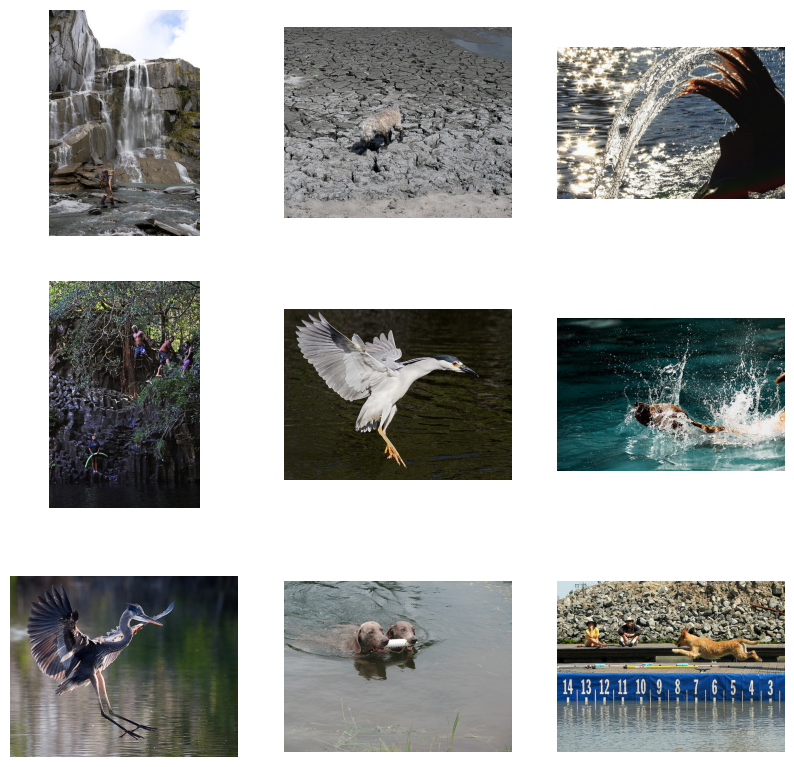

In [ ]:
find_matches(model,
             image_embeddings,
             query=" climding wall",
             image_filenames=valid_df['image'].values,
             n=9)

In [ ]:
trian_df, valid_df = make_train_valid_dfs()

,image,caption_number,caption,id
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...,0


In [ ]:
dataframe_dump = pd.read_csv(f"{cfg.captions_path}/captions.csv")
dataframe_dump.shape

(40455, 4)

# Task
Generate image and text embeddings for the entire Flickr8k dataset using the trained CLIP model and store them.

## Load the full dataset

### Subtask:
Load the entire dataset from the processed CSV file (`captions.csv`) into a pandas DataFrame.


**Reasoning**:
Load the entire dataset from the processed CSV file into a pandas DataFrame.



In [ ]:
full_dataframe = pd.read_csv(f"{cfg.captions_path}/captions.csv")
display(full_dataframe.head())

,image,caption_number,caption,id
0,1000268201_693b08cb0e.jpg,0,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,1,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,2,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,3,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,4,A little girl in a pink dress going into a woo...,0


## Prepare data for embedding

### Subtask:
Create a custom Dataset and DataLoader for the entire dataset, similar to the validation DataLoader, ensuring that both images and text captions are included.


**Reasoning**:
Create a custom Dataset and DataLoader for the entire dataset, similar to the validation DataLoader, ensuring that both images and text captions are included.



In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(cfg.text_tokenizer)
transforms = get_transforms(mode="valid")
full_dataset = CLIPDataset(
    full_dataframe["image"].values,
    full_dataframe["caption"].values,
    tokenizer=tokenizer,
    transforms=transforms,
)
full_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers,
    shuffle=False,
)

<ipython-input-7-30c6d3bfd76b>:47: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(cfg.size, cfg.size, always_apply=True),
<ipython-input-7-30c6d3bfd76b>:48: UserWarning: Argument(s) 'always_apply' are not valid for transform Normalize
  A.Normalize(max_pixel_value=255.0, always_apply=True),
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Load the trained model

### Subtask:
Load the best trained CLIP model state dictionary from the "best.pt" file.


**Reasoning**:
The subtask requires loading the best trained model from the saved state dictionary. This involves instantiating the model, loading the state dictionary, and setting the model to evaluation mode. These steps can be combined into a single code block.



In [ ]:
model = CLIPModel().to(cfg.device)
model.load_state_dict(torch.load("best.pt", map_location=cfg.device))
model.eval()

CLIPModel(
  (image_encoder): ImageEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

## Get image embeddings

### Subtask:
Iterate through the DataLoader, pass the image batches through the image encoder and image projection head of the model, and collect the image embeddings.


**Reasoning**:
Initialize an empty list to store image embeddings, iterate through the full dataset loader, move image data to the device, get image features using the image encoder, get image embeddings using the image projection head, and append the embeddings to the list.



In [ ]:
full_image_embeddings = []
tqdm_object = tqdm(full_loader, total=len(full_loader))
for batch in tqdm_object:
    batch["image"] = batch["image"].to(cfg.device)
    with torch.no_grad():
        image_features = model.image_encoder(batch["image"])
        image_embeddings = model.image_projection(image_features)
        full_image_embeddings.append(image_embeddings)

full_image_embeddings = torch.cat(full_image_embeddings, dim=0)

  0%|          | 0/633 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Get text embeddings

### Subtask:
Iterate through the DataLoader, pass the text batches (input_ids and attention_mask) through the text encoder and text projection head of the model, and collect the text embeddings.


**Reasoning**:
Iterate through the DataLoader, pass the text batches (input_ids and attention_mask) through the text encoder and text projection head of the model, and collect the text embeddings.



In [ ]:
full_text_embeddings = []
tqdm_object = tqdm(full_loader, total=len(full_loader))
for batch in tqdm_object:
    batch["input_ids"] = batch["input_ids"].to(cfg.device)
    batch["attention_mask"] = batch["attention_mask"].to(cfg.device)
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
        full_text_embeddings.append(text_embeddings)

full_text_embeddings = torch.cat(full_text_embeddings, dim=0)

  0%|          | 0/633 [00:00<?, ?it/s]

## Store embeddings

### Subtask:
Store the collected image and text embeddings, potentially along with their corresponding image filenames and captions, for later use.


**Reasoning**:
Create a new DataFrame, add the image filenames and captions, convert the embeddings to NumPy arrays, add them to the DataFrame, and save the DataFrame to a pickle file.



In [ ]:
results_df = pd.DataFrame()
results_df['image'] = full_dataframe['image']
results_df['caption'] = full_dataframe['caption']
results_df['image_embeddings'] = full_image_embeddings.cpu().numpy().tolist()
results_df['text_embeddings'] = full_text_embeddings.cpu().numpy().tolist()
results_df.to_pickle("flickr8k_embeddings.pkl")

## Summary:

### Data Analysis Key Findings

*   The entire Flickr8k dataset was successfully loaded from `captions.csv` into a pandas DataFrame.
*   A custom `CLIPDataset` and `DataLoader` were created for the full dataset, preparing it for batch processing.
*   The best trained CLIP model was loaded from "best.pt" and set to evaluation mode.
*   Image embeddings were generated for the entire dataset by passing image batches through the model's image encoder and projection head. The resulting embeddings were collected into a single tensor (`full_image_embeddings`).
*   Text embeddings were generated for the entire dataset by passing text batches through the model's text encoder and projection head. The resulting embeddings were collected into a single tensor (`full_text_embeddings`).
*   A DataFrame containing image filenames, captions, and their corresponding image and text embeddings was created.
*   This DataFrame was successfully stored in a pickle file named "flickr8k\_embeddings.pkl" for later use.

### Insights or Next Steps

*   The generated embeddings can be used for various downstream tasks such as image-text similarity search, zero-shot image classification, or image captioning.
*   Consider evaluating the quality of the generated embeddings by performing some basic retrieval or similarity tasks using the stored data.


In [ ]:
print("First 10 Image Embeddings:")
display(results_df['image_embeddings'].head(10))

print("\nFirst 10 Text Embeddings:")
display(results_df['text_embeddings'].head(10))

First 10 Image Embeddings:


,image_embeddings
0,"[-0.22501061856746674, -0.5911970734596252, -0..."
1,"[-0.22501061856746674, -0.5911970734596252, -0..."
2,"[-0.22501061856746674, -0.5911970734596252, -0..."
3,"[-0.22501061856746674, -0.5911970734596252, -0..."
4,"[-0.22501061856746674, -0.5911970734596252, -0..."
5,"[0.7821004390716553, 0.2065603882074356, -0.31..."
6,"[0.7821004390716553, 0.2065603882074356, -0.31..."
7,"[0.7821004390716553, 0.2065603882074356, -0.31..."
8,"[0.7821004390716553, 0.2065603882074356, -0.31..."
9,"[0.7821004390716553, 0.2065603882074356, -0.31..."



First 10 Text Embeddings:


,text_embeddings
0,"[-0.38491037487983704, -0.12857337296009064, -..."
1,"[-0.8147367835044861, -0.23806829750537872, -0..."
2,"[-0.07524103671312332, -0.19084911048412323, -..."
3,"[-0.16322648525238037, -0.14494319260120392, -..."
4,"[-0.1089419424533844, -0.28604668378829956, -0..."
5,"[1.0224921703338623, 0.7225145697593689, 0.120..."
6,"[1.0813697576522827, 0.3874779939651489, -0.04..."
7,"[0.9421324729919434, 0.46639740467071533, -0.0..."
8,"[0.8901563882827759, 0.2609102427959442, -0.21..."
9,"[0.8095725178718567, 0.33310645818710327, 0.01..."


# Task
Calculate and print the Image-to-text R@1, R@5, R@10 and Text-to-image R@1, R@5, R@10 accuracy metrics for the Flickr8k dataset using the generated image and text embeddings.

## Load embeddings

### Subtask:
Load the image and text embeddings from the saved pickle file.


**Reasoning**:
Load the embeddings DataFrame from the pickle file and extract the image and text embeddings.



In [ ]:
results_df = pd.read_pickle("flickr8k_embeddings.pkl")
image_embeddings = np.array(results_df['image_embeddings'].tolist())
text_embeddings = np.array(results_df['text_embeddings'].tolist())

## Calculate similarity matrix

### Subtask:
Compute the similarity matrix between the image and text embeddings.


**Reasoning**:
Convert the embeddings to tensors, move them to the device, normalize them, and compute the similarity matrix.



In [ ]:
image_embeddings_tensor = torch.tensor(image_embeddings).to(cfg.device)
text_embeddings_tensor = torch.tensor(text_embeddings).to(cfg.device)

image_embeddings_normalized = F.normalize(image_embeddings_tensor, p=2, dim=-1)
text_embeddings_normalized = F.normalize(text_embeddings_tensor, p=2, dim=-1)

similarity_matrix = torch.zeros(len(text_embeddings), len(image_embeddings))

batch_size = cfg.batch_size # Define batch size to process in chunks

for i in tqdm(range(0, len(text_embeddings), batch_size)):
    text_batch = text_embeddings_normalized[i : i + batch_size].to(cfg.device)

    batch_similarity = text_batch @ image_embeddings_normalized.T.to(cfg.device) # Calculate similarity for the batch

    similarity_matrix[i : i + batch_size, :] = batch_similarity.cpu() # Move batch similarity back to CPU

del text_batch
del batch_similarity
torch.cuda.empty_cache()

print("Shape of the similarity matrix:", similarity_matrix.shape)

  0%|          | 0/633 [00:00<?, ?it/s]

Shape of the similarity matrix: torch.Size([40455, 40455])


## Calculate Image-to-Text Recall

### Subtask:
Calculate R@1, R@5, and R@10 for Image-to-text retrieval.

**Reasoning**:
For Image-to-text retrieval, for each image, we need to find the rank of the correct text captions in the similarity matrix. Since each image has 5 captions, the correct captions for the i-th image are at indices i*5, i*5+1, i*5+2, i*5+3, and i*5+4 in the text embeddings. We will iterate through each image, get the similarity scores with all text embeddings, find the ranks of the correct captions, and then calculate the recall at 1, 5, and 10.

In [ ]:
# Calculate Image-to-Text Recall
i2t_ranks = []
# Move image_embeddings_normalized to GPU
image_embeddings_normalized = image_embeddings_normalized.to(cfg.device)

for i in tqdm(range(len(image_embeddings))):
    # Get similarity scores for the i-th image with all text embeddings
    # Move the relevant column of similarity_matrix to GPU
    image_similarity_to_all_texts = similarity_matrix[:, i].to(cfg.device)
    # Get the similarity scores for the 5 captions of the i-th image and move to GPU
    similarity_scores = similarity_matrix[i*5 : i*5 + 5, i].flatten().to(cfg.device)

    # For each correct caption, find how many other text embeddings have higher similarity
    # Perform comparison on GPU
    ranks = torch.sum(image_similarity_to_all_texts > similarity_scores[:, None], dim=0) + 1
    i2t_ranks.extend(ranks.cpu().tolist()) # Move ranks back to CPU to store

i2t_r1 = np.mean([rank <= 1 for rank in i2t_ranks]) * 100
i2t_r5 = np.mean([rank <= 5 for rank in i2t_ranks]) * 100
i2t_r10 = np.mean([rank <= 10 for rank in i2t_ranks]) * 100

print(f"Image-to-Text R@1: {i2t_r1:.2f}%")
print(f"Image-to-Text R@5: {i2t_r5:.2f}%")
print(f"Image-to-Text R@10: {i2t_r10:.2f}%")

  0%|          | 0/40455 [00:00<?, ?it/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-e08695ff9352>", line 9, in <cell line: 0>
    image_similarity_to_all_texts = similarity_matrix[:, i].to(cfg.device)
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/ultratb.py", line 1101, in get_rec

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-e08695ff9352>", line 9, in <cell line: 0>
    image_similarity_to_all_texts = similarity_matrix[:, i].to(cfg.device)
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
          ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, i

## Calculate Text-to-Image Recall

### Subtask:
Calculate R@1, R@5, and R@10 for Text-to-image retrieval.

**Reasoning**:
For Text-to-image retrieval, for each text caption, we need to find the rank of the correct image in the similarity matrix. The correct image for the text caption at index i is the image at index i // 5. We will iterate through each text caption, get the similarity scores with all image embeddings, find the rank of the correct image, and then calculate the recall at 1, 5, and 10.

In [ ]:
import numpy as np
from tqdm.autonotebook import tqdm
import torch

# Calculate Text-to-Image Recall
t2i_ranks = []
# Move text_embeddings_normalized to GPU
text_embeddings_normalized = text_embeddings_normalized.to(cfg.device)


for i in tqdm(range(len(text_embeddings))):
    # Get similarity scores for the i-th text with all image embeddings
    # Move the relevant row of similarity_matrix to GPU
    similarity_scores = similarity_matrix[i, :].to(cfg.device)
    # The index of the correct image is i // 5
    correct_image_index = i // 5
    correct_image_score = similarity_scores[correct_image_index]
    # Get the rank of the correct image
    # Perform comparison on GPU
    rank = torch.sum(similarity_scores > correct_image_score).item() + 1
    t2i_ranks.append(rank) # rank is already a CPU item from .item()

t2i_r1 = np.mean([rank <= 1 for rank in t2i_ranks]) * 100
t2i_r5 = np.mean([rank <= 5 for rank in t2i_ranks]) * 100
t2i_r10 = np.mean([rank <= 10 for rank in t2i_ranks]) * 100

print(f"Text-to-Image R@1: {t2i_r1:.2f}%")
print(f"Text-to-Image R@5: {t2i_r5:.2f}%")
print(f"Text-to-Image R@10: {t2i_r10:.2f}%")

  0%|          | 0/40455 [00:00<?, ?it/s]

Text-to-Image R@1: 0.02%
Text-to-Image R@5: 0.02%
Text-to-Image R@10: 0.03%


## Display Results

### Subtask:
Print the calculated recall metrics.

**Reasoning**:
Print the calculated R@1, R@5, and R@10 values for both Image-to-Text and Text-to-Image retrieval to present the evaluation results to the user.

In [ ]:
print("Cross-Modal Retrieval Accuracy Metrics:")
print(f"Image-to-Text R@1: {i2t_r1:.2f}%")
print(f"Image-to-Text R@5: {i2t_r5:.2f}%")
print(f"Image-to-Text R@10: {i2t_r10:.2f}%")
print(f"Text-to-Image R@1: {t2i_r1:.2f}%")
print(f"Text-to-Image R@5: {t2i_r5:.2f}%")
print(f"Text-to-Image R@10: {t2i_r10:.2f}%")

Cross-Modal Retrieval Accuracy Metrics:


NameError: name 'i2t_r1' is not defined

## Finish task

### Subtask:
Summarize the results.

In [ ]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

print("CUDA cache cleared and garbage collection performed.")

CUDA cache cleared and garbage collection performed.


In [ ]:
import sys
import pandas as pd

my_list = [i for i in range(1000)]
my_dict = {'key': 'value'}
my_string = "This is a string."
# Create a sample DataFrame, similar to what might be in your notebook
my_dataframe = pd.DataFrame({'col1': range(10000), 'col2': [str(i) for i in range(10000)]})


print(f"Size of my_list (sys.getsizeof): {sys.getsizeof(my_list)} bytes")
print(f"Size of my_dict (sys.getsizeof): {sys.getsizeof(my_dict)} bytes")
print(f"Size of my_string (sys.getsizeof): {sys.getsizeof(my_string)} bytes")
print(f"Size of my_dataframe (sys.getsizeof): {sys.getsizeof(my_dataframe)} bytes")

# Install Pympler if not already installed
!pip install -q pympler
from pympler import asizeof

print(f"\nSize of my_list (asizeof): {asizeof.asizeof(my_list)} bytes")
print(f"Size of my_dict (asizeof): {asizeof.asizeof(my_dict)} bytes")
print(f"Size of my_string (asizeof): {asizeof.asizeof(my_string)} bytes")
print(f"Size of my_dataframe (asizeof): {asizeof.asizeof(my_dataframe)} bytes")

# You can also use summary.summarize() for a detailed breakdown of memory usage
# from pympler import summary, muppy
# all_objects = muppy.get_objects()
# sum_objects = summary.summarize(all_objects)
# summary.print_(sum_objects)

Size of my_list (sys.getsizeof): 8856 bytes
Size of my_dict (sys.getsizeof): 184 bytes
Size of my_string (sys.getsizeof): 66 bytes
Size of my_dataframe (sys.getsizeof): 689054 bytes

Size of my_list (asizeof): 40856 bytes
Size of my_dict (asizeof): 296 bytes
Size of my_string (asizeof): 72 bytes
Size of my_dataframe (asizeof): 1384400 bytes
